### Introduction
Aggregate villages with 1 data point in to same village as missing

### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('../dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['price_per_area'] = df['total_price'] / df['building_area']
    df['log_price_per_area'] = np.log1p(df['price_per_area'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    return np.clip(np.expm1(y_pred), 0, None) * df['building_area']

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_price_per_area'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self): pass
    
    def fit_transform(self, df, cols_cat, cols_bin, rare_village_threshold):
        df = df.copy()
        # Rare village
        village_counts = df['village'].value_counts()
        rare_village = set(village_counts.index[village_counts <= rare_village_threshold])
        df.loc[df['village'].isin(rare_village), 'village'] = np.nan
        
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [11]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.01,
              'lambda_l2': 0.01,
             }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

#### Round 1

In [12]:
%%time
params_gsearch1 = {'feature_fraction': [0.5],}

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin, rare_village_threshold=1)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
    
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
        
        y_pred = model.predict(df_val[cols_feats])
        
        y_pred_final = target_inverse_transform(df_val, y_pred)
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00983823
[4000]	valid_0's mape: 0.0097087
[6000]	valid_0's mape: 0.00967763
[8000]	valid_0's mape: 0.00966643
[10000]	valid_0's mape: 0.00966103
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00966103
5732.865944730274
==== Fold 2 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00978691
[4000]	valid_0's mape: 0.00966173
[6000]	valid_0's mape: 0.00963312
[8000]	valid_0's mape: 0.00962

In [13]:
display(gsearch_results1)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01)),
  5732.866531135926,
  [5732.865944730274, 5750.866557152551, 5714.867091524954]]]

#### Round 2

In [14]:
%%time
params_gsearch2 = {'feature_fraction': [0.5],}

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin, rare_village_threshold=2)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    # grid search
    # pick top 3 params from round 1
    for result1 in gsearch_results1[:3]:
        params1 = dict(result1[0])
        for values in itertools.product(*[params_gsearch2[key] for key in params_gsearch2]):
            params = params1.copy()
            params.update( dict(zip(params_gsearch2.keys(), values)) )
            print('params:', params)

            model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
            
            y_pred = model.predict(df_val[cols_feats])

            y_pred_final = target_inverse_transform(df_val, y_pred)

            score = cal_score(df_val['total_price'], y_pred_final)
            print(score)
            tuple_params = tuple(params.items())
            gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results2 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results2.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00983823
[4000]	valid_0's mape: 0.0097087
[6000]	valid_0's mape: 0.00967763
[8000]	valid_0's mape: 0.00966643
[10000]	valid_0's mape: 0.00966103
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00966103
5732.865944730274
==== Fold 2 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00978691
[4000]	valid_0's mape: 0.00966173
[6000]	valid_0's mape: 0.00963312
[8000]	valid_0's mape: 0.00962

In [16]:
display(gsearch_results2)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01)),
  5732.866531135926,
  [5732.865944730274, 5750.866557152551, 5714.867091524954]]]

### Conclusion

Best params:  
  ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.01),  
   ('lambda_l2', 0.01)),  

Best scores: 
  5732.866531135926,  
  [5732.865944730274, 5750.866557152551, 5714.867091524954]


Baseline (without rare village)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01)),
  5732.866531135926,
  [5732.865944730274, 5750.866557152551, 5714.867091524954]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1)),
  5725.866633027713,
  [5720.8662887491255, 5745.866445693379, 5710.867164640635]]

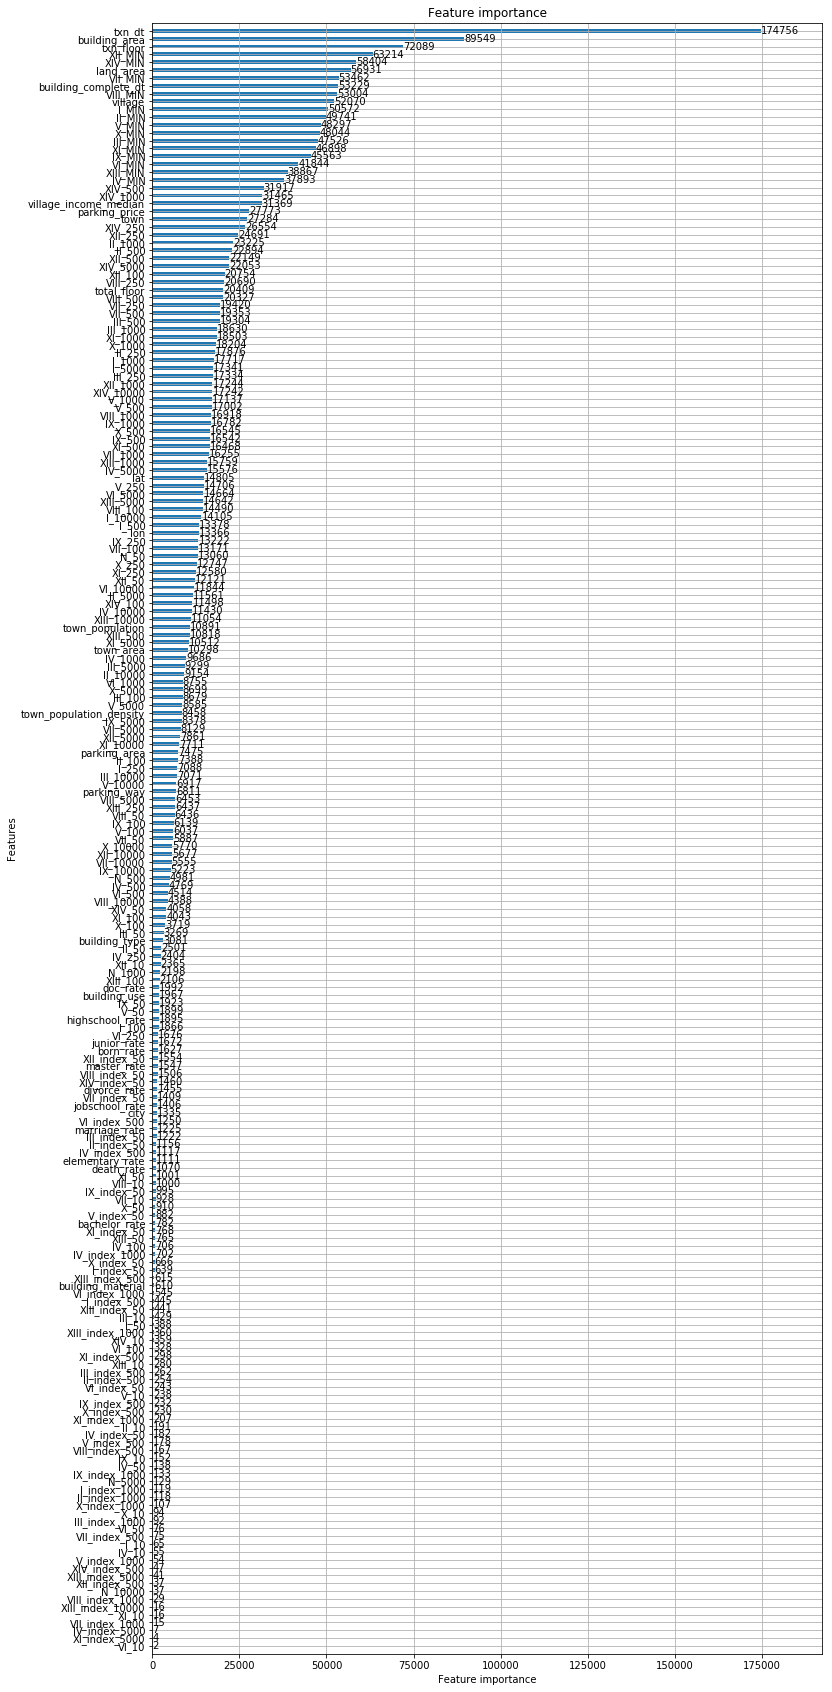

In [17]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

In [ ]:
lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()